In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)


# Load remote patient monitoring (RPM) procedure codes from CMS

In [4]:
df = pd.read_csv('Medicare_Physician_Other_Practitioners_by_Provider_and_Service_2019 2.csv')
df = df[~(df['HCPCS_Cd'] == 93264)]
print(len(df))

866


In [8]:
cols_keep = ['Rndrng_NPI','Rndrng_Prvdr_First_Name','Rndrng_Prvdr_MI','Rndrng_Prvdr_Last_Org_Name',\
             'Rndrng_Prvdr_Crdntls','Rndrng_Prvdr_State_Abrvtn','Rndrng_Prvdr_Type','HCPCS_Cd','HCPCS_Desc',\
             'Tot_Benes','Tot_Srvcs','Avg_Sbmtd_Chrg','Avg_Mdcr_Pymt_Amt']
df = df[cols_keep]

mapper = [(['Internal Medicine'],'Internal Medicine'),
          (['Family Practice','General Practice'],'Family/General Practice'),
          (['Cardiology','Interventional Cardiology','Clinical Cardiac Electrophysiology',\
            'Advanced Heart Failure and Transplant Cardiology'],'Cardiology'),
          (['Nurse Practitioner','Physician Assistant'],'NP/PA'),
          (['Pulmonary Disease'],'Pulmonary Disease'),
          (['Emergency Medicine','Critical Care (Intensivists)'],'Emergency Medicine'),
          (['Endocrinology'],'Endocrinology')]

df['Provider_type'] = 'Other'
for i in mapper:
    df.loc[df['Rndrng_Prvdr_Type'].isin(i[0]), 'Provider_type'] = i[1]
df.drop_duplicates(inplace = True)
print(len(df))


866


# Bar chart of RPM utilization distributed across clinical area, by different healthcare metrics (e.g. # of patients, # of doctors, $ spent)

100.1
100.0
100.0
100.19999999999999


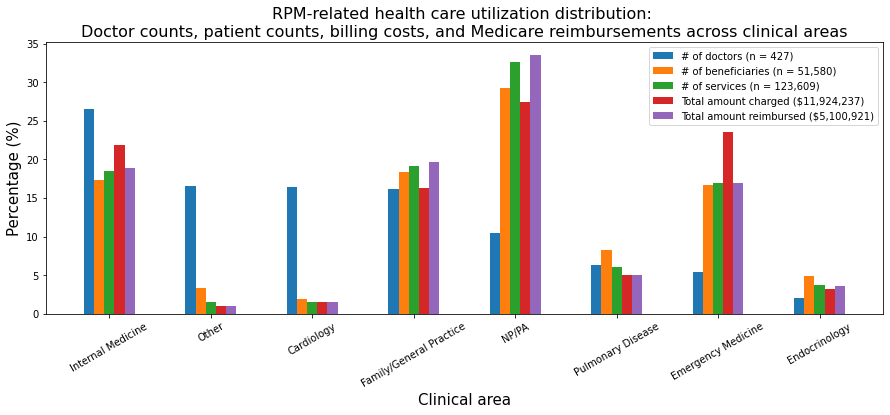

In [11]:
df['Sbmtd_Chrg'] = df['Avg_Sbmtd_Chrg']*df['Tot_Srvcs']
df['Mdcr_Pymt_Amt'] = df['Avg_Mdcr_Pymt_Amt']*df['Tot_Srvcs']

cols1 = ['Tot_Benes','Tot_Srvcs']
cols2 = ['Sbmtd_Chrg','Mdcr_Pymt_Amt']

unique_providers = df.drop_duplicates(subset = ['Rndrng_NPI', 'Provider_type'])
df_provider_type = unique_providers.Provider_type.value_counts().reset_index()
providers_denom = df['Rndrng_NPI'].nunique()
df_provider_type['Provider_type_percent']  = round(100*df_provider_type['Provider_type']/providers_denom,1)

l = [df_provider_type]

for col in cols1+cols2:

    provider_df = df.groupby('Provider_type')[[col]].sum().reset_index()
    N = df[col].sum()
    provider_df['{}_percentage'.format(col)] = round(100*provider_df[col]/N,1)
    l.append(provider_df)

df_merged= pd.concat(l, axis = 1)
df_merged = df_merged.loc[:,~df_merged.columns.duplicated()]

labels = df_merged['index']
providers = df_merged['Provider_type_percent']
beneficiaries = df_merged['Tot_Benes_percentage']
services = df_merged['Tot_Srvcs_percentage']
charges = df_merged['Sbmtd_Chrg_percentage']
payments = df_merged['Mdcr_Pymt_Amt_percentage']

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, providers, width, label='# of doctors (n = {:,})'.format(df_merged['Provider_type'].sum()))
rects2 = ax.bar(x -1*width, beneficiaries, width, label='# of beneficiaries (n = {:,})'.format(df_merged['Tot_Benes'].sum()))
rects3 = ax.bar(x -0*width, services, width, label='# of services (n = {:,})'.format(df_merged['Tot_Srvcs'].sum()))
rects4 = ax.bar(x +1*width, charges, width, label='Total amount charged (${:,})'.format(int(df_merged['Sbmtd_Chrg'].sum())))
rects5 = ax.bar(x +2*width, payments, width, label='Total amount reimbursed (${:,})'.format(int(df_merged['Mdcr_Pymt_Amt'].sum())))

ax.set_ylabel('Percentage (%)',size = 15)
ax.set_xlabel('Clinical area',size = 15)
ax.set_title('RPM-related health care utilization distribution: \nDoctor counts, patient counts, billing costs, and Medicare reimbursements across clinical areas',size = 16)
plt.xticks(ticks = x, labels =labels, rotation = 30)
ax.legend()
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

# Line plot of telehealth procedure codes over time

7632
1908


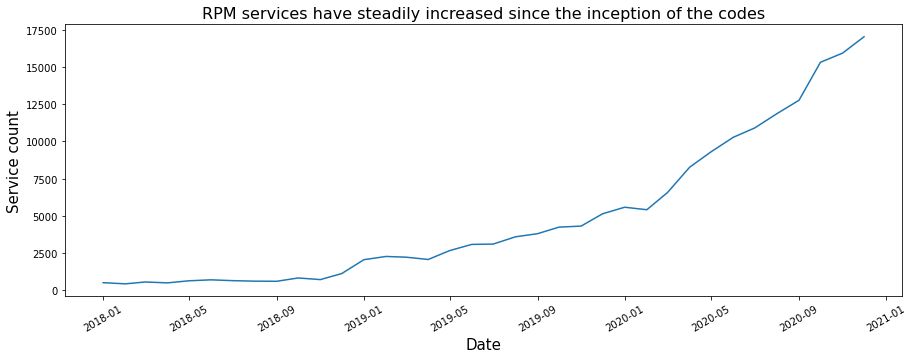

In [12]:
telehealth = pd.read_csv('telehealth_smallcell.csv')
print(len(telehealth))
rpm = telehealth[telehealth['TelehealthType'] == 'Remote patient monitoring']
print(len(rpm))
rpm['ServiceCount'] = pd.to_numeric(rpm['ServiceCount'], errors = 'coerce')
rpm_summary = rpm.groupby('Month')['ServiceCount'].sum().reset_index()
rpm_summary['date'] = pd.to_datetime(rpm_summary['Month'], format = '%Y%m').dt.date
fig, ax = plt.subplots()
plt.plot(rpm_summary['date'], rpm_summary['ServiceCount'])
ax.set_ylabel('Service count',size = 15)
ax.set_xlabel('Date',size = 15)
ax.set_title('RPM services have steadily increased since the inception of the codes',size = 16)
plt.xticks(rotation = 30)
fig = plt.gcf()
fig.set_size_inches(15, 5)
plt.show()

In [ ]:
#Pulmonary Disease
pulmonary_df = df[df['Provider_type'] == 'Pulmonary Disease']
pulmonary_df['provider_name'] = pulmonary_df['Rndrng_Prvdr_First_Name'] +' '+ pulmonary_df['Rndrng_Prvdr_Last_Org_Name']
pulmonary_df = pulmonary_df[['provider_name','Rndrng_NPI','Rndrng_Prvdr_Crdntls','Rndrng_Prvdr_State_Abrvtn']].drop_duplicates()
print(len(pulmonary_df))
ri_df = df[df['Rndrng_Prvdr_State_Abrvtn'].isin(['MA','CT'])]
print(len(ri_df))
ri_df['provider_name'] = ri_df['Rndrng_Prvdr_First_Name'] +' '+ ri_df['Rndrng_Prvdr_Last_Org_Name']
ri_df = ri_df[['provider_name','Rndrng_NPI','Rndrng_Prvdr_Crdntls','Rndrng_Prvdr_State_Abrvtn']].drop_duplicates()
ri_df.style.hide_index()
